This notebook is aimed to take a folder of excel files of spectra, subtract a shared backgroud spectra and average the results of the spectra before plotting it and printing it out

## Import packages

In [1]:
%matplotlib ipympl
import numpy as np

import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.integrate import quad

import pandas as pd

import csv

import os
from os.path import isfile, join

## Folder Path and other constant variables

In [2]:
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\Talisker10_cuvette_discon2" #Insert folder pathway that contains the excel files
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\Talisker10_cuvette_discon1"
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\Talisker10_cuvette_continuous1"

#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Quartz_cuvette\Talisker10_cuvette_discon2"
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Quartz_cuvette\Talisker10_cuvette_discon1"
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Quartz_cuvette\Talisker10_cuvette_continuous1"

#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Cuvette_LongTime_Discon"
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Cuvette_LongTime_Discon2"

#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Cuvette_LongTime_Discon_LPower"
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Cuvette_LongTime_Discon_LPower2"

#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Cuvette_LongTime-Discon_LPower_LongInterval"
folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\JWRLA vs TK10\JWRLA"
folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\JWRLA vs TK10\TRK10"

folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\JWRLA_QCuvette_LPower_LongDiscon"

folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\JWRLA_QCuvette_Continuous1"

rayleighPeak = 785

## Method 1 for data Correction

In [14]:
import os
from os.path import isfile, join
paths = os.listdir(folderPathway)

files = []
for x in paths:
    
    if(isfile(join(folderPathway,x))):
        if(x.endswith(".csv")):
            files.append(x)



backgroundPath = ""
backgroundData = np.array([])
dataPath = np.array([])
fileNames = np.array([])
data = []
correctData = []


#gets the data from the files
for x in files:
    #gets the background data, the file name including the background data must include the key word Background
    if(x.find("background") != -1):
        backgroundPath = x
        
        raw_data = pd.read_csv((folderPathway+"/"+x), sep=",")
        backgroundData = raw_data.to_numpy()
    
    #all data that is not in a file with the name background will be added as data
    else:
        dataPath = np.append(dataPath, x)
        fileNames = np.append(fileNames, x)
        
        rawdata = pd.read_csv((folderPathway+"/"+x), sep=",")
        data.append(rawdata.to_numpy())
        

#If there is no background data file then the background data is set to zero
if(len(backgroundData) == 0):
    temp = []
    for i in range(len(data[0])):
        temp.append([0,0])    
    backgroundData = np.array(temp)
    print(backgroundData)

for i in range(len(data)):
    x = data[i][:,0]
    y= data[i][:,1] - backgroundData[:,1]

    temp = []
    
    for j in range(len(x)):
        temp.append([x[j],y[j]])
    
    correctData.append(np.array(temp))
    
    

directory = "correctedData"
  
# Parent Directory path
parent_dir = folderPathway
  
# Path
path = os.path.join(parent_dir, directory)


#attempts to create a new directory
try:
    os.mkdir(path)
except:
  print("File already exists")


for i in range(len(correctData)):
    fileName = "corrected_" + fileNames[i]
    filePath = os.path.join(path,fileName)
    with open(filePath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerows(correctData[i])

## Method 2 for data correction
Scale the background data to set the corrected average between the Rayleigh peak and the jump due to the notch filter to be zero. Run Method 1 first to get the background data and the uncorrected data from the folder

In [15]:
#scale backgroundData
#what is the average reading of 

wavelength = 790 # The wavelength (in nm) that we would like to see the progression of in time


#find index for wavelength close to chosen wavelength
minIndex = 0
minDifference = abs(data[0][0][0]- wavelength)
for i in range(1,len(data[0])):
    difference = abs(data[0][i][0] - wavelength)
    #print(difference)
    if difference < minDifference:
        minDifference = difference
        minIndex = i
        
wavelength = 798 # The wavelength (in nm) that we would like to see the progression of in time


#find index for wavelength close to chosen wavelength
maxIndex = 0
minDifference = abs(data[0][0][0]- wavelength)
for i in range(1,len(data[0])):
    difference = abs(data[0][i][0] - wavelength)
    #print(difference)
    if difference < minDifference:
        minDifference = difference
        maxIndex = i
        
    
correctData2 = []
for i in range(len(data)):
    
    average = np.mean(data[i][minIndex:maxIndex,1])
    meanBackground = np.mean(backgroundData[minIndex:maxIndex,1])
    
    factor = average/meanBackground
    
    x = data[i][:,0]
    y = data[i][:,1] - factor*backgroundData[:,1]

    temp = []
    
    for j in range(len(x)):
        temp.append([x[j],y[j]])
    
    correctData2.append(np.array(temp))
    



directory = "Method2CorrectedData"
  
# Parent Directory path
parent_dir = folderPathway
  
# Path
path = os.path.join(parent_dir, directory)


#attempts to create a new directory
try:
    os.mkdir(path)
except:
  print("File already exists")


for i in range(len(correctData2)):
    fileName = "Method2_Corrected_" + fileNames[i]
    filePath = os.path.join(path,fileName)
    with open(filePath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerows(correctData2[i])

## Plot the correct data and write it to a folder
The corrected data calculated by subtracting the background is plotted and saved to a folder

In [19]:
plt.close("all")

In [17]:
directory = "correctedDataPlots"
  
# Parent Directory path
parent_dir = folderPathway
  
# Path
path = os.path.join(parent_dir, directory)

#attempts to create a new directory
try:
    os.mkdir(path)
except:
  print("File already exists")


for i in range(len(correctData)):
    fileName = "corrected_Plot_" + fileNames[i] + ".png"
    filePath = os.path.join(path,fileName)


    fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
    ax1.plot(correctData[i][:,0],correctData[i][:,1],'b')
    
    #Adds the peaks
    #peaks, info = find_peaks(correctData[i][:,1],height=100, prominence = 100)
    #ax1.plot(correctData[i][peaks,0],correctData[i][peaks,1],'rx',markersize=6,)
    
    
    ax1.set_title(fileName)
    ax1.set_ylabel('signal')
    ax1.set_xlabel("wavelength, (nm)")
    ax1.legend(["signal",'peaks']);
    ax1.set_xlim(rayleighPeak,correctData[0][-1][0])
    ax1.set_ylim(0,15000)
    ax1.grid();

    fig.savefig(filePath)
    plt.close(fig)

## Plot Method 2's corrected Data and save
the corrected data calculated by the second method is plotted and saved to a folder

In [18]:
directory = "Method2CorrectedDataPlots"
  
# Parent Directory path
parent_dir = folderPathway
  
# Path
path = os.path.join(parent_dir, directory)

#attempts to create a new directory
try:
    os.mkdir(path)
except:
  print("File already exists")


for i in range(len(correctData2)):
    fileName = "method2_corrected_Plot_" + fileNames[i] + ".png"
    filePath = os.path.join(path,fileName)


    fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
    ax1.plot(correctData2[i][:,0],correctData2[i][:,1],'b')
    
    #Adds the peaks
    #peaks, info = find_peaks(correctData2[i][:,1],height=100, prominence = 100)
    #ax1.plot(correctData2[i][peaks,0],correctData2[i][peaks,1],'rx',markersize=6,)
    
    
    ax1.set_title(fileName)
    ax1.set_ylabel('signal')
    ax1.set_xlabel("wavelength, (nm)")
    ax1.legend(["signal",'peaks']);
    ax1.set_xlim(rayleighPeak,correctData2[0][-1][0])
    ax1.set_ylim(0,15000)
    ax1.grid();

    fig.savefig(filePath)
    plt.close(fig)

## Average data and plot it
The Average of all the data is calculated and plotted

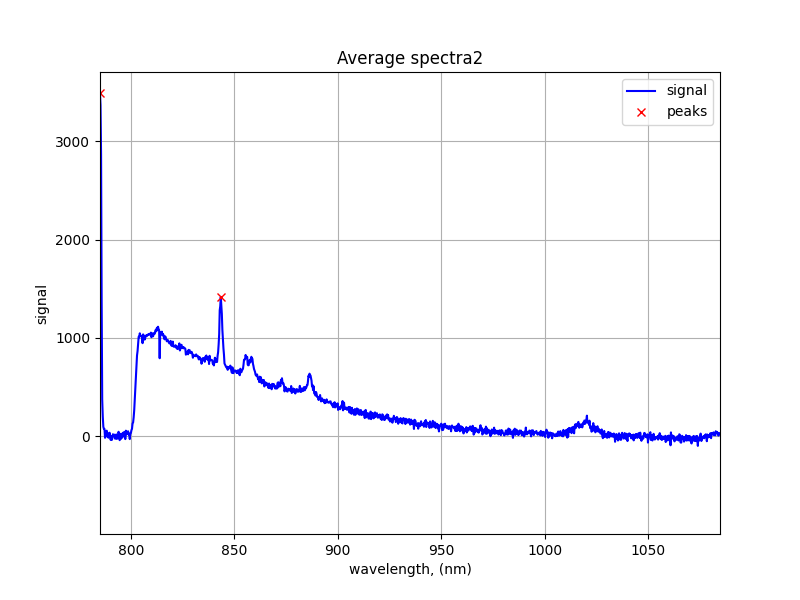

In [22]:
total = correctData2[0]

for i in range(1,len(correctData2)):
    x = correctData2[0][:,0]
    y = correctData2[i][:,1] + total[:,1]
    
    temp = []
    for j in range(len(x)):
        temp.append([x[j],y[j]])
        
    total = np.array(temp)


average = total
average[:,1] = total[:,1]/len(correctData2)


peaks, info = find_peaks(average[:,1],height=100, prominence = 1000)

# visual check
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))


ax1.plot(average[:,0],average[:,1],'b')
ax1.plot(average[peaks,0],average[peaks,1],'rx',markersize=6,)

ax1.set_title('Average spectra2')
ax1.set_ylabel('signal')
ax1.set_xlabel("wavelength, (nm)")
ax1.legend(["signal",'peaks']);
ax1.set_xlim(rayleighPeak,average[-1][0])
ax1.grid();



#Save the plot to the same folder as the original data
fileName = "Method2_corrected_Average_plot.png"
filePath = os.path.join(folderPathway,fileName)
fig.savefig(filePath)
#plt.close(fig)


## Power Normalised Plots

Gets the corrected data and then using power readings given by the user will normalise the spectra relative to the first spectra

Import a folder

In [6]:
#Folder Pathways

#Polystirene cuvette corrected dicon, continuou then discon run
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\Talisker10_cuvette_discon2\correctedData"
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\Talisker10_cuvette_discon1\correctedData"
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\Talisker10_cuvette_continuous1\correctedData"

#Quartz cuvette corrected dicon, continuou then discon run
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Quartz_cuvette\Talisker10_cuvette_discon2\correctedData"
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Quartz_cuvette\Talisker10_cuvette_discon1\correctedData"
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Quartz_cuvette\Talisker10_cuvette_continuous1\correctedData"

#Long Time corrected discontinuous laser power 500mW
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Cuvette_LongTime_Discon2\correctedData" #120 samples
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Cuvette_LongTime_Discon\Method2CorrectedData"#240 samples

#Long Time corrected discontinuous laser power 130mW
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Cuvette_LongTime_Discon_LPower\correctedData" # 120 samples
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Cuvette_LongTime_Discon_LPower2\correctedData" # 120 samples

#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Cuvette_LongTime-Discon_LPower_LongInterval\correctedData"

#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\JWRLA vs TK10\TRK10\correctedData"

#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\JWRLA_QCuvette_LPower_LongDiscon\correctedData"
#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\JWRLA_QCuvette_LPower_LongDiscon\Method2CorrectedData"#

#folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\JWRLA_QCuvette_Discon1\Method2CorrectedData"
folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\JWRLA_QCuvette_Continuous1\Method2CorrectedData"
folderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\JWRLA_QCuvette_Discon2\Method2CorrectedData"

#Long Time corrected discontinuous laser power 1300mW (about 100Mw at source)

import os
from os.path import isfile, join
paths = os.listdir(folderPathway)

files = []
for x in paths:
    
    if(isfile(join(folderPathway,x))):
        if(x.endswith(".csv")):
            files.append(x)



dataPath = np.array([])
fileNames = np.array([])
data = []


#gets the data from the files
for x in files:
    dataPath = np.append(dataPath, x)
    fileNames = np.append(fileNames, x)
        
    rawdata = pd.read_csv((folderPathway+"/"+x), sep=",")
    data.append(rawdata.to_numpy())
 

Get the relative power for each spectra

In [106]:
#Get the power reading for each spectra from the user
power = []

counter = 0
while len(power) < len(data):
    print("File name: " + files[counter])
    counter+=1
    temp = float(input("Enter Power: "))
    power.append(temp)


File name: Method2_Corrected_talisker10_cuvette_continuous1_120.csv
Enter Power: 3.47
File name: Method2_Corrected_talisker10_cuvette_continuous1_121.csv
Enter Power: 3.46
File name: Method2_Corrected_talisker10_cuvette_continuous1_122.csv
Enter Power: 3.46
File name: Method2_Corrected_talisker10_cuvette_continuous1_123.csv
Enter Power: 3.40
File name: Method2_Corrected_talisker10_cuvette_continuous1_180.csv
Enter Power: 3.43
File name: Method2_Corrected_talisker10_cuvette_continuous1_181.csv
Enter Power: 3.43
File name: Method2_Corrected_talisker10_cuvette_continuous1_182.csv
Enter Power: 3.45
File name: Method2_Corrected_talisker10_cuvette_continuous1_20.csv
Enter Power: 3.44
File name: Method2_Corrected_talisker10_cuvette_continuous1_21.csv
Enter Power: 3.43
File name: Method2_Corrected_talisker10_cuvette_continuous1_22.csv
Enter Power: 3.44
File name: Method2_Corrected_talisker10_cuvette_continuous1_23.csv
Enter Power: 3.43
File name: Method2_Corrected_talisker10_cuvette_continuous

Normalise the data with laser power

In [210]:
#calculate the normalised data
normalisedData = []

for i in range(len(data)):
    
    
    peaks, info = find_peaks(data[i][:,1],height=100, prominence = 1000)
    normalisation = (1/(power[i]*data[i][peaks[1]][2]))
    
    x = data[i][:,0]
    y = data[i][:,1] * normalisation 

    temp = []
    
    for j in range(len(x)):
        temp.append([x[j],y[j]])
    
    normalisedData.append(np.array(temp))



#write data to excel file
directory = "normalisedData"
 
# Parent Directory path
parent_dir = folderPathway
  
# Path
path = os.path.join(parent_dir, directory)


#attempts to create a new directory
try:
    os.mkdir(path)
except:
  print("File already exists")


for i in range(len(normalisedData)):
    fileName = "Normalised_" + fileNames[i]
    filePath = os.path.join(path,fileName)
    with open(filePath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerows(normalisedData[i])

IndexError: index 2 is out of bounds for axis 0 with size 2

Normalise the spectra with respect to the 843 peak

In [7]:
#peak, info = find_peaks(data[18][:,1],height=10000, prominence = 1000)
normalisedData = []

 
for i in range(len(data)):

    normalisation = 1
    peaks, info = find_peaks(data[i][:,1],height=2500, prominence = 800)
    #print(fileNames[i])
    #print(peaks)
    if len(peaks) >=2 :
        normalisation = (1/data[i][peaks[-1]][1])
        normalisation = (1/data[i][967][1])
    
        x = data[i][:,0]
        y = data[i][:,1] * normalisation 

        temp = []
        
        for j in range(len(x)):
            temp.append([x[j],y[j]])
        
        normalisedData.append(np.array(temp))
    
    else:
        normalisation = 1/data[i][:,1]

        x = data[i][:,0]
        y = data[i][:,1] * normalisation 

        temp = []
        
        for j in range(len(x)):
            temp.append([x[j],y[j]])
        
        normalisedData.append(np.array(temp))


#write data to excel file
directory = "nData"
 
# Parent Directory path
parent_dir = folderPathway
  
# Path
path = os.path.join(parent_dir, directory)


#attempts to create a new directory
try:
    os.mkdir(path)
except:
  print("File already exists")


for i in range(len(normalisedData)):
    fileName = "Normalised_" + fileNames[i]
    filePath = os.path.join(path,fileName)
    with open(filePath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerows(normalisedData[i])

Plot the normalised data

In [8]:
#Plot and store in a folder

directory = "nDataPlots"
  
# Parent Directory path
parent_dir = folderPathway
  
# Path
path = os.path.join(parent_dir, directory)


#attempts to create a new directory
try:
    os.mkdir(path)
except:
  print("File already exists")
        
for i in range(len(normalisedData)):
    fileName = "norm_plot" + (fileNames[i]) + ".png"
    filePath = os.path.join(path,fileName)


    fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
    ax1.plot(normalisedData[i][:,0],normalisedData[i][:,1],'b')
    
    #Adds the peaks
    #peaks, info = find_peaks(normalisedData[i][:,1],height=100, prominence = 100)
    #ax1.plot(normalisedData[i][peaks,0],normalisedData[i][peaks,1],'rx',markersize=6,)
    
    
    ax1.set_title(fileName)
    ax1.set_ylabel('signal')
    ax1.set_xlabel("wavelength, (nm)")
    ax1.legend(["signal",'peaks']);
    ax1.set_xlim(800,normalisedData[i][-1][0])
    ax1.set_ylim(0,1.5)
    ax1.grid();

    fig.savefig(filePath)
    plt.close(fig)

## Plot the area under the spectra with respect to time
The area under the spectra is calculated, this gives us an idea of whether the flourecence is decreasing or not. When running for the first time or with a new data set the section that enters the time must be re-run

Import data

In [20]:
#Import data from a folder

#Polystirene cuvette normalised corrected dicon, continuou then discon run
#FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\Talisker10_cuvette_discon2\Method2CorrectedData\normalisedData"
#FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\Talisker10_cuvette_discon1\Method2CorrectedData\normalisedData"
#FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\Talisker10_cuvette_continuous1\Method2CorrectedData\normalisedData"

#Quartz cuvette normalised corrected dicon, continuou then discon run
#FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Quartz_cuvette\Talisker10_cuvette_discon2\Method2CorrectedData\normalisedData"
#FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Quartz_cuvette\Talisker10_cuvette_discon1\Method2CorrectedData\normalisedData"
#FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Quartz_cuvette\Talisker10_cuvette_continuous1\Method2CorrectedData\normalisedData"

# Long time data
#FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Cuvette_LongTime_Discon\correctedData\normalisedData"
#FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Cuvette_LongTime_Discon\Method2CorrectedData\normalisedData2"
#FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Cuvette_LongTime_Discon_LPower\Method2CorrectedData\normalisedData"

#FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Cuvette_LongTime_Discon_LPower2\correctedData\normalisedData"

#FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Cuvette_LongTime-Discon_LPower_LongInterval\correctedData\nData"

FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\JWRLA vs TK10\TRK10\correctedData\nData"

#FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\JWRLA_QCuvette_LPower_LongDiscon\correctedData\nData"
FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\JWRLA_QCuvette_LPower_LongDiscon\Method2CorrectedData\nData"#

FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\JWRLA_Quartz_Cuvette\JWRLA_QCuvette_Discon1\Method2CorrectedData\nData"
#FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\JWRLA_Quartz_Cuvette\JWRLA_QCuvette_Continuous1\Method2CorrectedData\nData"
#FolderPathway = r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\JWRLA_Quartz_Cuvette\JWRLA_QCuvette_Discon2\Method2CorrectedData\nData"

import os
from os.path import isfile, join
paths = os.listdir(FolderPathway)

files = []
for x in paths:
    
    if(isfile(join(FolderPathway,x))):
        if(x.endswith(".csv")):
            files.append(x)



dataPath = np.array([])
fileNames = np.array([])
data = []

#gets the data from the files
for x in files:
    dataPath = np.append(dataPath, x)
    fileNames = np.append(fileNames, x)
        
    rawdata = pd.read_csv((FolderPathway+"/"+x), sep=",")
    data.append(rawdata.to_numpy())

Time Section

In [21]:
# Add the relavent time data for the program, each time a new data set is entered this must be re-entered
time = [120,121,122,123,180,181,182,20,21,22,23,30,300,301,302,31,32,33,5,6,60,600,601,61,62,63,7,8]

"""counter = 0
while (len(time) < len(data)):
    
    #Manually enter the data
    print("File name: " + files[counter])
    temp = int(input("Enter the time at which this was taken: "))
        
    #can calculate the time from the file name
    #temp = int(files[counter].split("(")[1].split(")")[0])*20
    
    time.append(temp)
    counter+=1"""

'counter = 0\nwhile (len(time) < len(data)):\n    \n    #Manually enter the data\n    print("File name: " + files[counter])\n    temp = int(input("Enter the time at which this was taken: "))\n        \n    #can calculate the time from the file name\n    #temp = int(files[counter].split("(")[1].split(")")[0])*20\n    \n    time.append(temp)\n    counter+=1'

Calculate Integral for each data set and plot it

The Standard Deviation in the value of area unde the spectra is: 14


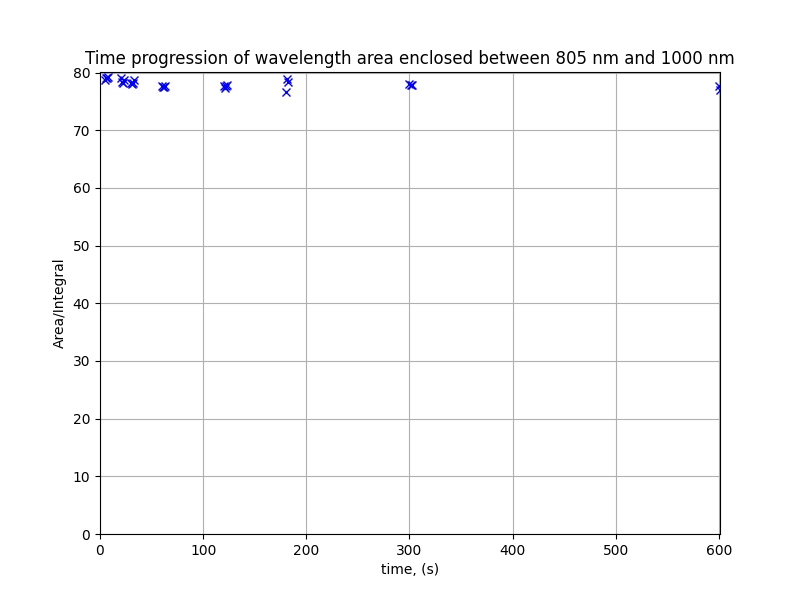

In [22]:

wavelength = 805 # The wavelength (in nm) that we would like to see the progression of in time


#find index for wavelength close to chosen wavelength
minIndex = 0
minDifference = abs(data[0][0][0]- wavelength)
for i in range(1,len(data[0])):
    difference = abs(data[0][i][0] - wavelength)
    #print(difference)
    if difference < minDifference:
        minDifference = difference
        minIndex = i
        
wavelength = 1000 # The wavelength (in nm) that we would like to see the progression of in time


#find index for wavelength close to chosen wavelength
maxIndex = 0
minDifference = abs(data[0][0][0]- wavelength)
for i in range(1,len(data[0])):
    difference = abs(data[0][i][0] - wavelength)
    #print(difference)
    if difference < minDifference:
        minDifference = difference
        maxIndex = i

y = []
counter = 0
for i in data:
    integral = np.trapz(data[counter][minIndex:maxIndex,1], data[counter][minIndex:maxIndex,0])
    y.append(integral)
        

    counter+=1

standardDeviation = np.std(y) 
print("The Standard Deviation in the value of area unde the spectra is: " + str(int(standardDeviation)))
    
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
ax1.plot(time[0:len(data)-1],y[0:len(data)-1],'bx')
#ax1.plot(time,y[0:len(data)],'bx')

ax1.set_title("Time progression of wavelength area enclosed between " + str(int(data[0][minIndex][0])) + " nm and " + str(int(data[0][maxIndex][0])) + " nm")
ax1.set_ylabel('Area/Integral')
ax1.set_xlabel("time, (s)")
ax1.set_xlim([0,max(time)])
ax1.set_ylim([0, max(y[0:len(data)-1])*1.01])
#ax1.set_ylim([min(y[0:len(data)-1])*0.99, max(y)*1.01])
#ax1.set_ylim([min(y[0:len(data)])*0.99, max(y)*1.01])
#ax1.set_ylim([0,max(y)*1.01])
ax1.grid();


fileName = "Time_Progression_of_Area_under_Spectra.csv"
filePath = os.path.join(FolderPathway,fileName)
with open(filePath, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerows([time[0:len(data)-1],y[0:len(data)-1]])
    
fig.savefig(filePath+".png")

## Plot any number of data sets on the same graph

[array([[15.45297323, 15.42360301, 15.3517938 , 15.53057401, 15.47675049,
        15.40425694, 15.45852441, 15.71742532, 15.79295143, 15.59549761,
        15.53582958, 15.49083119, 15.48032092, 15.46627112, 15.66463781,
        15.56043237, 15.53203192, 15.50639018, 15.61322106, 15.95727515,
        15.38654569, 15.81923291, 15.68003824, 15.43945696, 15.50108215,
        15.40416783, 16.0172288 , 16.0153405 ]]), array([[14.84767524, 14.63858662, 14.70103813, 14.63757593, 14.79338368,
        14.66726806, 14.71049853, 14.8146784 , 14.91791304, 14.85105852,
        14.87570927, 14.84153518, 14.51899095, 14.44459833, 14.4930732 ,
        14.87905927, 14.87566383, 14.76608304, 14.64202626, 15.11930757,
        14.8104264 , 14.57009951, 14.58945883, 14.77208209, 14.71021274,
        14.77268551, 15.0598636 , 15.17206902]]), array([[16.20938671, 16.26988798, 16.00469468, 15.97648328, 16.12372636,
        15.85563482, 15.85049975, 16.10464946, 16.03551269, 15.93153874,
        16.18065226, 16

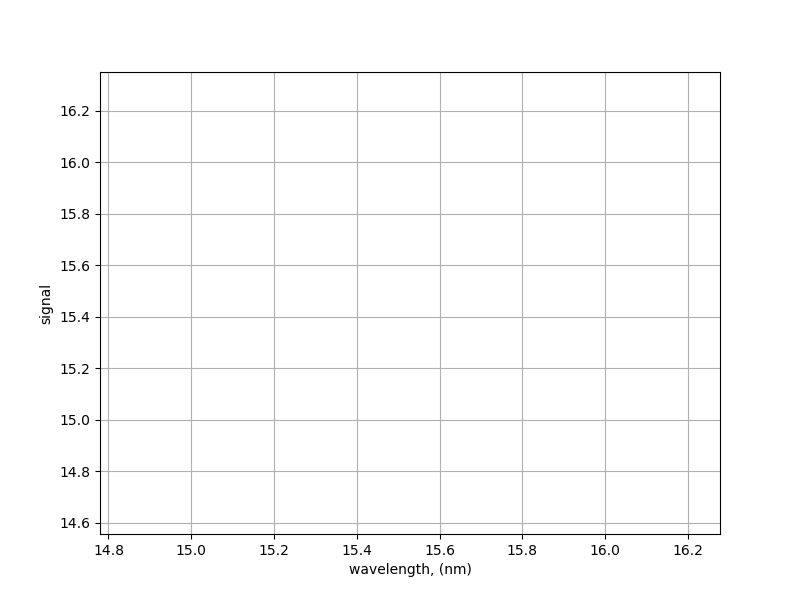

In [160]:
pathway = []
#pathway.append(r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Quartz_cuvette\Talisker10_cuvette_discon1\normalisedCorrectedData\normalised_corrected_talisker10_cuvette_discon1_5.csv") #Add the name of a file
#pathway.append(r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Quartz_cuvette\Talisker10_cuvette_discon1\normalisedCorrectedData\normalised_corrected_talisker10_cuvette_discon1_300.csv")
#pathway.append(r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Quartz_cuvette\Talisker10_cuvette_discon1\normalisedCorrectedData\normalised_corrected_talisker10_cuvette_discon1_600.csv")

#pathway.append(r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\Talisker10_cuvette_continuous1\normalisedCorrectedData\normalised_corrected_talisker10_cuvette_continuous1_5.csv") #Add the name of a file
#pathway.append(r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\Talisker10_cuvette_continuous1\normalisedCorrectedData\normalised_corrected_talisker10_cuvette_continuous1_300.csv")
#pathway.append(r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\Talisker10_cuvette_continuous1\normalisedCorrectedData\normalised_corrected_talisker10_cuvette_continuous1_600.csv")
#pathway.append(r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\Talisker10_cuvette_discon1\normalisedCorrectedData\normalised_corrected_talisker10_cuvette_discon1_5.csv")
#pathway.append(r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\Talisker10_cuvette_discon2\talisker10_cuvette_discon2_background.csv")

#pathway.append(r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Cuvette_LongTime_Discon\Method2CorrectedData\Method2_Corrected_talisker10_cuvette_repeated_discon_(148)_25.csv")
pathway.append(r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\talisker10_cuvette_discon1\Method2CorrectedData\normalisedData\Time_Progression_of_Area_under_Spectra.csv")
pathway.append(r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\talisker10_cuvette_discon2\Method2CorrectedData\normalisedData\Time_Progression_of_Area_under_Spectra.csv")
pathway.append(r"C:\Users\edwar\OneDrive\Documents\University\Summer_2023_Internship\Data\Photodamage\Talisker10_Polystirene_cuvette\talisker10_cuvette_continuous1\Method2CorrectedData\normalisedData\Time_Progression_of_Area_under_Spectra.csv")

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

import os
from os.path import isfile, join

arbitrary = []
#apowers = [3.67,3.67,3.67,3.84,3.86]

for x in pathway:
    
    if(isfile(x)):
        if(x.endswith(".csv")):
            rawdata = (pd.read_csv(x)).to_numpy()
            arbitrary.append(rawdata)
            
print(arbitrary)   
counter = 0
for x in arbitrary:
    #print(arbitrary[counter][:,1])
    
    x = arbitrary[counter][:,0]
    y = arbitrary[counter][:,1] #* (np.amax(arbitrary[0][:,1])/np.amax(arbitrary[counter][:,1])) * (apowers[counter]/apowers[0])

    
    ax1.plot(x, y, label = os.path.basename(pathway[counter]))
    #ax1.set_xlim(rayleighPeak,x[-1])
    
    #Adds the peaks
    #peaks, info = find_peaks(y,height=100, prominence = 3000)
    #ax1.plot(x[peaks[1]],y[peaks[1]],'rx',markersize=6,)
    
    counter+=1
            
ax1.set_ylabel('signal')
ax1.set_xlabel("wavelength, (nm)")
#ax1.legend();
#ax1.set_xlim(rayleighPeak,rawData[i][-1][0])
#ax1.set_ylim(0,15000)
ax1.grid();